In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [6]:
with open('data/matches/2417/structured_data.json', 'r') as f:
    match_dict = json.load(f)

In [7]:
len(match_dict)

68101

In [11]:
with open('data/matches/2417/match_data.json', 'r') as f:
    match_data_dict = json.load(f)

In [14]:
match_data_dict.keys()

dict_keys(['referees', 'date_time', 'home_team', 'away_team', 'away_team_kit', 'home_team_coach', 'status', 'pitch_length', 'players', 'away_team_coach', 'ball', 'pitch_width', 'competition_edition', 'stadium', 'home_team_kit', 'competition_round', 'away_team_score', 'id', 'home_team_score'])

In [21]:
[player for player in match_data_dict['players'] if player['team_player_id']==1538]

[{'injured': False,
  'own_goal': 0,
  'last_name': 'Müller',
  'goal': 0,
  'red_card': 0,
  'number': 25,
  'id': 10308,
  'trackable_object': 10318,
  'team_id': 100,
  'birthday': '1989-09-13',
  'end_time': None,
  'first_name': 'Thomas',
  'player_role': {'acronym': 'CM', 'id': 8, 'name': 'Center Midfield'},
  'start_time': '00:00:00',
  'yellow_card': 0,
  'team_player_id': 1538}]

In [36]:
filtered_data = [
    {'frame': frame['frame'], 'x': pos['x'], 'y': pos['y']}
    for frame in match_dict
    for pos in frame['data']
    if pos.get('track_id') == 8 
]
filtered_data

[{'frame': 1150, 'x': 0.330776769972, 'y': -13.5860110021},
 {'frame': 1151, 'x': 0.466471433832, 'y': -13.6288838404},
 {'frame': 1152, 'x': 0.551087471604, 'y': -13.6565564272},
 {'frame': 1153, 'x': 0.584624883288, 'y': -13.6690287622},
 {'frame': 1154, 'x': 0.530846007203, 'y': -13.6621186888},
 {'frame': 1155, 'x': 0.364111204998, 'y': -13.635793014},
 {'frame': 1156, 'x': 0.503738863581, 'y': -13.6437577113},
 {'frame': 1157, 'x': 0.571955892528, 'y': -13.6487827665},
 {'frame': 1158, 'x': 0.554436121044, 'y': -13.6397938864},
 {'frame': 1159, 'x': 0.582427315769, 'y': -13.6548970086},
 {'frame': 1160, 'x': 0.67635446645, 'y': -13.6619880767},
 {'frame': 1161, 'x': 0.68137838344, 'y': -13.6545048923},
 {'frame': 1162, 'x': 0.76333460023, 'y': -13.6641811313},
 {'frame': 1163, 'x': 0.777473323985, 'y': -13.6530901657},
 {'frame': 1164, 'x': 0.615866890374, 'y': -13.5962003841},
 {'frame': 1165, 'x': 0.555217656587, 'y': -13.559154098},
 {'frame': 1166, 'x': 0.566634483038, 'y': -1

In [51]:
df_player = pd.DataFrame(filtered_data).head(10)
df_player['frame'] = df_player['frame'].astype('int')
df_player

,frame,x,y
0,1150,0.330777,-13.586011
1,1151,0.466471,-13.628884
2,1152,0.551087,-13.656556
3,1153,0.584625,-13.669029
4,1154,0.530846,-13.662119
5,1155,0.364111,-13.635793
6,1156,0.503739,-13.643758
7,1157,0.571956,-13.648783
8,1158,0.554436,-13.639794
9,1159,0.582427,-13.654897


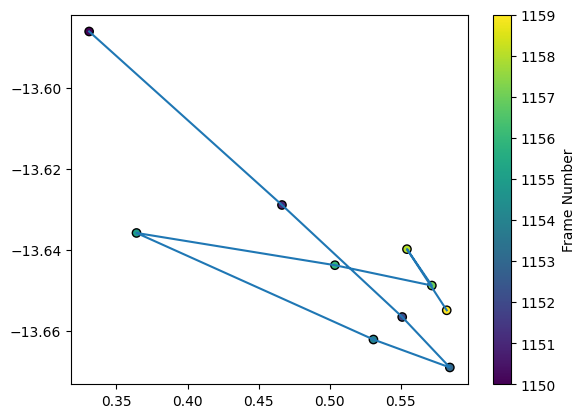

In [55]:
plt.scatter(df_player['x'], df_player['y'], c=df_player['frame'], cmap='viridis', edgecolors='k')
plt.colorbar(label='Frame Number')
plt.plot(df_player['x'], df_player['y'])

In [ ]:
# Pour trouver x et y quand on connaît la distance parcourue

def interpolate_positions(df):
    """
    Interpole les positions manquantes en conservant la direction précédente.
    
    df : DataFrame contenant les colonnes ['time', 'x', 'y', 'distance']
    """

    for i in range(1, len(df)):
        if np.isnan(df.loc[i, 'x']) or np.isnan(df.loc[i, 'y']):
            # Dernier point valide
            last_valid_idx = i - 1
            while last_valid_idx >= 0 and (np.isnan(df.loc[last_valid_idx, 'x']) or np.isnan(df.loc[last_valid_idx, 'y'])):
                last_valid_idx -= 1
            
            if last_valid_idx < 0:
                continue  # Pas de point valide avant, on ne peut pas interpoler

            # Récupérer la dernière direction valide
            if last_valid_idx > 0:
                dx = df.loc[last_valid_idx, 'x'] - df.loc[last_valid_idx - 1, 'x']
                dy = df.loc[last_valid_idx, 'y'] - df.loc[last_valid_idx - 1, 'y']
                norm = np.sqrt(dx**2 + dy**2)
                if norm > 0:
                    dx /= norm
                    dy /= norm
            else:
                dx, dy = 1, 0  # Direction par défaut si on n'a qu'un point

            # Appliquer la distance prédite pour estimer la nouvelle position
            distance = df.loc[i, 'distance']
            df.loc[i, 'x'] = df.loc[last_valid_idx, 'x'] + distance * dx
            df.loc[i, 'y'] = df.loc[last_valid_idx, 'y'] + distance * dy
    
    return df

# Exemple d'utilisation
data = {
    'time': [0, 10, 20, 30, 40, 50],
    'x': [0, 1, np.nan, np.nan, 4, 5],
    'y': [0, 1, np.nan, np.nan, 4, 5],
    'distance': [0, 1.41, 1.41, 1.41, 1.41, 1.41]  # Distances estimées
}

df = pd.DataFrame(data)
df = interpolate_positions(df)

In [ ]:
# autre manière de le coder

# Fonction pour calculer la vitesse (distance divisée par le temps)
def calculate_speed(df):
    speeds = []
    for i in range(1, len(df)):
        dx = df['x'].iloc[i] - df['x'].iloc[i-1]
        dy = df['y'].iloc[i] - df['y'].iloc[i-1]
        distance = np.sqrt(dx**2 + dy**2)
        time_interval = 0.25  # 0.25 secondes entre chaque point
        speed = distance / time_interval  # vitesse en m/s
        speeds.append(speed)
    speeds.insert(0, 0)  # La première vitesse est nulle (pas de déplacement)
    return speeds

# Interpolation des positions manquantes en utilisant la direction et la vitesse
def interpolate_missing_positions(df):
    # Calcul des vitesses et directions
    df['speed'] = calculate_speed(df)
    
    for i in range(1, len(df)-1):
        if pd.isnull(df['x'].iloc[i]):  # Si la position x est manquante
            prev_speed = df['speed'].iloc[i-1]
            next_speed = df['speed'].iloc[i+1]
            prev_position = np.array([df['x'].iloc[i-1], df['y'].iloc[i-1]])
            next_position = np.array([df['x'].iloc[i+1], df['y'].iloc[i+1]])

            # Direction estimée comme une combinaison des directions avant et après
            direction = (next_position - prev_position) / np.linalg.norm(next_position - prev_position)
            
            # Interpolation basée sur la vitesse et la direction
            interpolated_position = prev_position + direction * prev_speed * 0.25  # Le facteur 0.25 est la durée entre les points
            
            df['x'].iloc[i] = interpolated_position[0]
            df['y'].iloc[i] = interpolated_position[1]
    
    return df

In [ ]:
# Pour lisser la vitesse avec une moving average

window_size = 5 
df['smoothed_velocity'] = df['velocity'].rolling(window=window_size, min_periods=1).mean()

# avec np.convolve
df['smoothed_velocity'] = np.convolve(df['velocity'], np.ones(window_size)/window_size, mode='same')

si on lisse les vitesses sur l'ensemble du dataset : il faut partir du x et y d'origine, puis ajuster les (x,y) suivants à partir des distances smoothées

In [ ]:
# Pour compter les sprints maintenus

# Sample DataFrame
df = pd.DataFrame({
    'frame': [1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157],
    'x': [-3.4, -1.2, -2.2, -3.0, -1.0, -2.8, -3.5, -3.6],
    'y': [2.0, 0.2, 1.1, 1.2, 0.9, 1.3, 1.0, 0.8],
})

# Example: Calculate the speed in m/s (already done in previous code)
df['x_diff'] = df['x'].diff()
df['y_diff'] = df['y'].diff()
df['distance'] = np.sqrt(df['x_diff']**2 + df['y_diff']**2)
time_diff = 0.01
df['speed_m_s'] = df['distance'] / time_diff

# Define a sprint as speed > 7 m/s
df['is_sprint'] = df['speed_m_s'] > 7

# Identify when sprints are consecutive (group consecutive True values)
# Cumsum enables to define new "id" of sprints
df['sprint_group'] = (df['is_sprint'] != df['is_sprint'].shift()).cumsum()

# Count the number of sprints maintained for more than 4 frames
sprint_durations = df.groupby('sprint_group')['is_sprint'].sum()
maintained_sprints = sprint_durations[sprint_durations > 4].count()

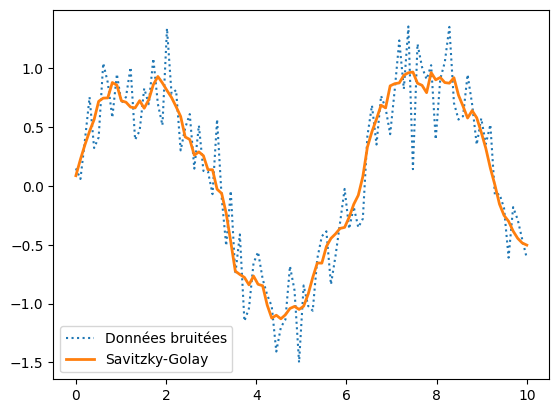

In [17]:
# Générer des données bruitées
np.random.seed(42)
t = np.linspace(0, 10, 100)  # Temps
y = np.sin(t) + np.random.normal(scale=0.3, size=len(t))  # Signal bruité

# Appliquer Savitzky-Golay
y_smooth = savgol_filter(y, window_length=10, polyorder=2)

# Afficher les résultats
plt.plot(t, y, label="Données bruitées", linestyle="dotted")
plt.plot(t, y_smooth, label="Savitzky-Golay", linewidth=2)
plt.legend()
plt.show()

In [ ]:
# déterminer s'il s'agit d'un appel en profondeur

def calculate_speed(df):
    speeds = []
    for i in range(1, len(df)):
        dx = df['x'].iloc[i] - df['x'].iloc[i-1]
        dy = df['y'].iloc[i] - df['y'].iloc[i-1]
        distance = np.sqrt(dx**2 + dy**2)
        time_interval = 0.25  # 0.25 secondes entre chaque point
        speed = distance / time_interval  # vitesse en m/s
        speeds.append(speed)
    speeds.insert(0, 0)  # La première vitesse est nulle (pas de déplacement)
    return speeds

# Fonction pour calculer l'accélération (changement de vitesse)
def calculate_acceleration(speeds):
    accelerations = []
    for i in range(1, len(speeds)):
        acceleration = speeds[i] - speeds[i-1]
        accelerations.append(acceleration)
    accelerations.insert(0, 0)  # La première accélération est nulle
    return accelerations

# Fonction pour déterminer si la course correspond à un appel en profondeur
def is_run_depth_call(df, threshold_speed=3, threshold_acceleration=1, threshold_angle=30):
    # Calcul des vitesses
    df['speed'] = calculate_speed(df)
    speeds = df['speed'].values
    
    # Calcul de l'accélération
    accelerations = calculate_acceleration(speeds)
    df['acceleration'] = accelerations
    
    # Vérifier si la vitesse et l'accélération dépassent les seuils
    if df['speed'].max() > threshold_speed and df['acceleration'].max() > threshold_acceleration:
        # Vérifier l'angle de déplacement pour détecter un mouvement linéaire vers la profondeur
        for i in range(1, len(df)-1):
            dx1 = df['x'].iloc[i] - df['x'].iloc[i-1]
            dy1 = df['y'].iloc[i] - df['y'].iloc[i-1]
            dx2 = df['x'].iloc[i+1] - df['x'].iloc[i]
            dy2 = df['y'].iloc[i+1] - df['y'].iloc[i]
            
            # Calcul de l'angle entre les deux vecteurs de déplacement
            angle = np.degrees(np.arccos((dx1*dx2 + dy1*dy2) / (np.sqrt(dx1**2 + dy1**2) * np.sqrt(dx2**2 + dy2**2))))
            
            # Si l'angle est faible, cela indique un mouvement linéaire vers la profondeur
            if angle < threshold_angle:
                return True  # L'appel en profondeur est détecté
    
    return False  # Aucun appel en profondeur détecté

In [ ]:
# Modèle de Pitch Control simple

# Paramètres
lambda_decay = 4  # Facteur de décroissance de la probabilité
max_speed = 5.5  # Vitesse max du joueur en m/s (peut être personnalisée)
pitch_length = 105  # Longueur du terrain (m)
pitch_width = 68  # Largeur du terrain (m)
grid_size = 1  # Taille des cellules en mètres

# Génération d'une grille du terrain
x_grid = np.arange(0, pitch_length, grid_size)
y_grid = np.arange(0, pitch_width, grid_size)
grid_points = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1, 2)

# Fonction pour calculer le temps d'arrivée d'un joueur à chaque point de la grille
def calculate_time_to_reach(player_x, player_y, speed_x, speed_y, grid):
    distances = np.sqrt((grid[:, 0] - player_x)**2 + (grid[:, 1] - player_y)**2)
    player_speed = np.sqrt(speed_x**2 + speed_y**2)
    times = distances / (player_speed + 1e-6)  # Ajouter une petite valeur pour éviter la division par 0
    return times

# Fonction pour calculer le Pitch Control sur toute la grille
def compute_pitch_control(players, grid):
    """
    players : DataFrame contenant les positions et vitesses des joueurs
    grid : Points du terrain sur lesquels on veut estimer le contrôle
    
    Retourne une matrice de probabilité de contrôle
    """
    num_points = len(grid)
    num_players = len(players)
    
    # Stocke les temps d'arrivée de chaque joueur pour chaque point de la grille
    arrival_times = np.full((num_players, num_points), np.inf)

    for i, (_, player) in enumerate(players.iterrows()):
        arrival_times[i, :] = calculate_time_to_reach(player['x'], player['y'], player['vx'], player['vy'], grid)
    
    # Pour chaque point de la grille, déterminer le temps minimum parmi tous les joueurs
    min_times = np.min(arrival_times, axis=0)

    # Calculer la probabilité de contrôle pour chaque joueur
    pitch_control = np.zeros(num_points)
    
    for i, (_, player) in enumerate(players.iterrows()):
        probabilities = np.exp(-lambda_decay * (arrival_times[i, :] - min_times))
        pitch_control += probabilities if player['team'] == 'A' else -probabilities

    return pitch_control.reshape(len(x_grid), len(y_grid))

# Exemple de données de joueurs
players_data = pd.DataFrame([
    {'team': 'A', 'x': 50, 'y': 34, 'vx': 2, 'vy': 0},
    {'team': 'B', 'x': 60, 'y': 34, 'vx': -2, 'vy': 0},
    {'team': 'A', 'x': 30, 'y': 20, 'vx': 3, 'vy': 1},
    {'team': 'B', 'x': 80, 'y': 50, 'vx': -3, 'vy': -1},
])
 
# Calcul du pitch control
pitch_control_matrix = compute_pitch_control(players_data, grid_points)

# Affichage du Pitch Control
plt.figure(figsize=(10, 6))
plt.imshow(pitch_control_matrix.T, origin='lower', extent=[0, pitch_length, 0, pitch_width], cmap='coolwarm', alpha=0.8)
plt.colorbar(label="Contrôle (-1 : équipe B, +1 : équipe A)")

# Affichage des positions des joueurs
for _, player in players_data.iterrows():
    plt.scatter(player['x'], player['y'], color='blue' if player['team'] == 'A' else 'red', edgecolors='k', s=100)

plt.title("Pitch Control")
plt.xlabel("Longueur du terrain (m)")
plt.ylabel("Largeur du terrain (m)")
plt.show()

In [ ]:
# modèle simple d'xP avec tracking data

# Calcul de quelques features
df["distance_pass"] = np.sqrt((df["x_receveur"] - df["x_passeur"])**2 + (df["y_receveur"] - df["y_passeur"])**2)
df["angle_pass"] = np.arctan2(df["y_receveur"] - df["y_passeur"], df["x_receveur"] - df["x_passeur"])
df["speed_passeur"] = np.sqrt(df["vx_passeur"]**2 + df["vy_passeur"]**2)
df["speed_receveur"] = np.sqrt(df["vx_receveur"]**2 + df["vy_receveur"]**2)
df["defenders_near_passeur"] = df["density_on_pass_path"].apply(lambda x: np.clip(x, 0, 5))  # Normalisation

# Sélection des features et de la cible
features = [
    "distance_pass", "angle_pass", "speed_passeur", "speed_receveur", 
    "defenders_near_passeur", "defenders_near_receveur", "pitch_control_receveur", 
    "pressure_passeur", "pressure_receveur"
]
X = df[features]
y = df["pass_success"]  # 1 = réussite, 0 = échec

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entraînement du modèle
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Prédiction et évaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilité de réussite

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.3f}")
print(f"AUC: {auc:.3f}")

In [ ]:
# déterminer la distance d'un joueur adverse par rapport à une ligne de passe

# même logique pour déterminer si un joueur adverse se dirige vers le ballon (pour le pressing)

# permet de calculer la distance d'un point à une droite

def distance_to_pass_line(x_passeur, y_passeur, x_receveur, y_receveur, x_adversaire, y_adversaire):
    """
    Calcule la distance entre un adversaire et la ligne de passe.
    
    x_passeur, y_passeur : Coordonnées du passeur
    x_receveur, y_receveur : Coordonnées du receveur
    x_adversaire, y_adversaire : Coordonnées de l’adversaire
    
    Retourne la distance de l’adversaire à la ligne de passe.
    """
    # Cas particulier : Passe verticale (éviter division par zéro)
    if x_passeur == x_receveur:
        return abs(x_adversaire - x_passeur)
    
    # Calcul de la pente et de l'ordonnée à l'origine de la ligne de passe
    m = (y_receveur - y_passeur) / (x_receveur - x_passeur)
    b = y_passeur - m * x_passeur
    
    # Coordonnées du point projeté perpendiculairement sur la ligne
    x_proj = (x_adversaire + m * (y_adversaire - b)) / (1 + m**2)
    y_proj = m * x_proj + b
    
    # Distance entre l’adversaire et le point projeté
    distance = np.sqrt((x_adversaire - x_proj)**2 + (y_adversaire - y_proj)**2)
    
    return distance

# Exemple d'utilisation avec un DataFrame
df = pd.DataFrame({
    "x_passeur": [30], "y_passeur": [40],
    "x_receveur": [70], "y_receveur": [50],
    "x_adversaire": [50], "y_adversaire": [55]
})

df["distance_adversaire_ligne_passe"] = df.apply(lambda row: 
    distance_to_pass_line(row["x_passeur"], row["y_passeur"], row["x_receveur"], row["y_receveur"], 
                          row["x_adversaire"], row["y_adversaire"]), axis=1)

print(df[["x_adversaire", "y_adversaire", "distance_adversaire_ligne_passe"]])